# Policy Learning I - Binary Treatment



<font color="#fa8072">Note: this chapter is in 'beta' version and may be edited in the near future.</font>

A few chapters ago, we learned how to estimate the average effect of a binary treatment (ATE), that is, the value of treating everyone in a population versus treating no one. Once that was established, we asked whether certain subgroups could react differently to the treatment, as we learned how to estimate such heterogeneous treatment effects (HTE). Then, in the previous chapter, we learned how to aggregate these heterogeneous effects to estimate the average outcome that would be attained if treatment assignment were to follow a particular rule, that is, if we were to treat only individuals with certain observable characteristics (policy evaluation). In this chapter, we will learn how to search the space of available treatment rules to approximately _maximize_ the average outcome across the population. That is, we will answer questions of the type: "_who_ should be treated?" We'll call this problem **policy learning**. 

We'll make a distinction between parametric and non-parametric policies, just as we did with predictive models. Parametric policies are simpler and depend only on a fixed number of parameters, whereas nonparametric policies can increase in complexity with the data. As we'll discuss below, there will be situations in which one or the other will be more appropriate.

For now, we'll work with the same toy simulation setting that we used in the previous chapter. 


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.mlab as mlab
import random 
import econml
import time
from patsy import dmatrices
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from scipy.stats import norm, expon, binom
from econml.grf import RegressionForest, CausalIVForest as instrumental_forest
from econml.dml import CausalForestDML as causal_forest
from econml.policy import PolicyForest, PolicyTree 
random.seed(12)

In [2]:
# A randomized setting.
n, p, e = 1000, 4, .5
x = np.reshape(np.random.uniform(0, 1, n*p), (n, p))
w = binom.rvs(1, p = e, size = n)
# w = np.random.binomial(1, e, n)
# x = np.random.normal(size = (n, p))
y = e * (x[:, 0] - e) + w * (x[:, 1] - e) + .1 * np.random.normal(0, 1, n)

data = pd.DataFrame(x)
data.columns = ['x_1', 'x_2', 'x_3', 'x_4']
data["y"], data["w"] = y, w

# data = pd.read_csv("cap6_data/test.csv")

outcome, treatment, covariates = "y", "w", list(data.columns)[1:5]
data.head(4)

# covariates

,x_1,x_2,x_3,x_4,y,w
0,0.221269,0.773029,0.346335,0.000354,-0.220284,0
1,0.092454,0.906579,0.930120,0.054099,0.204438,1
2,0.105970,0.002074,0.059774,0.751227,-0.249381,0
3,0.965888,0.530794,0.405995,0.210640,0.242687,1


## Non-parametric policies

In the HTE chapter we define the conditional average treatment effect (CATE) function

$$
  \tau(x) := \mathop{\mathrm{E}}[Y_i(1) - Y_i(0) | X_i = x],
$$ (cate)

that is, the average effect of a binary treatment conditional on observable charateristics. If we knew {eq}`cate`, then a natural policy would be to assigns individuals to treatment their CATE is positive,

$$
  \pi^{*} = \mathbb{I}\{\tau(x) \geq 0\}.
$$

More generally, if treating that individual costs a known amount $c(x)$, 

$$
  \pi^{*} = \mathbb{I}\{\tau(x) \geq c(x)\}.
$$

Of course, we don't know {eq}`cate`. However, we can obtain an estimate $\widehat{\tau}(\cdot)$ using any flexible (i.e., non-parametric) method as we learned in the HTE chapter, and then obtain a policy estimate

$$
  \hat{\pi}(x) = \mathbb{I}\{ \widehat{\tau}(x) \geq 0\},
$$

replacing the zero threshold by some appropriate cost function if needed.

Once we have an estimated policy, we need to estimate its value. To obtain accurate estimates, we must ensure appropriate **data-splitting**. We cannot estimate and evaluate a policy using the same data set, because that would lead to an overestimate of the value of the policy. One option here is to divide the data into training and test subsets, fit $\widehat{\tau}(\cdot)$ in the training subset and evaluate it in the test subset. This is analogous to what we saw in prediction problems: if we try to evaluate our predictions on the training set, we will overestimate how good our predictions are. 

The next snippet estimates the conditional treatment effect function via a Lasso model with splines. Note the data splitting.


In [3]:
# Preparing to run a regression with splines (\\piecewise polynomials).
# Note that if we have a lot of data we should increase the argument `df` below.
# The optimal value of `df` can be found by cross-validation
# i.e., check if the value of the policy, estimated below, increases or decreases as `df` varies. 

def bs_x(x_n, d_f = 5, add = True):
    bs_n = " bs(" + covariates[x_n] + " , df = " + str(d_f) + ") * w "
    if add:
        bs_n = "+" + bs_n
    return bs_n
fmla_xw = "y ~ " +  bs_x(0, add = False) + bs_x(1) + bs_x(2) + bs_x(3)
fmla_xw

'y ~  bs(x_2 , df = 5) * w + bs(x_3 , df = 5) * w + bs(x_4 , df = 5) * w + bs(y , df = 5) * w '

In [4]:
# Data-splitting
## Define training and evaluation sets

data_train, data_test = train_test_split(data, test_size = .5, random_state=1) 

## Contruct matrices 

y_train, xw_train = dmatrices(fmla_xw, data_train)
y_test, xw_test = dmatrices(fmla_xw, data_test)

y_test, y_train = np.ravel(y_test), np.ravel(y_train)

In [5]:
# Fitting the outcome model on the *training* data
model_m = LassoCV(cv = 10, random_state=12)
model_m.fit(xw_train, y_train)
data_0 = data_test.copy()
data_1 = data_test.copy()

# Predict outcome E[Y|X,W=w] for w in {0, 1} on the *test* data
data_0[treatment] = 0
data_1[treatment] = 1

## Construct matirces
y0, xw0 = dmatrices(fmla_xw, data_0)
y1, xw1 = dmatrices(fmla_xw, data_1)

# Predict values
mu_hat_1 = model_m.predict(xw1)
mu_hat_0 = model_m.predict(xw0)

# Extract rows 
n_row, n_col = data_test.shape

# Computing the CATE estimate tau_hat 
tau_hat = mu_hat_1 - mu_hat_0

# Assignment if tau.hat is positive (or replace by non-zero cost if applicable)
pi_hat = tau_hat > 0

# Estimate assignment probs e(x). 
# (This will be useful for evaluation via AIPW scores a little later)

# In randomized settings assignment probabilities are fixed and known.
e_hat = np.repeat(.5, n_row)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e-02, tolerance: 3.178e-03


On the test set, we can evaluate this policy as we learned in the previous chapter. In randomized settings, a simple estimator based on the difference in means is available.



In [6]:
# Only valid in randomized settings.

a = pi_hat == 1
Y = data_test[outcome]
W = data_test[treatment]

## Extract, value estimate and standard error
def extr_val_sd(y_eval, w_eval, a, cost = 0):
    c_1 = a & (w_eval == 1)
    c_0 = np.logical_not(a) & (w_eval == 0)

    y_eval_main = pd.DataFrame(y_eval)
    y_eval_main['c_1'] = c_1
    y_eval_main['c_0'] = c_0

    y_0 = y_eval_main.loc[y_eval_main['c_0'] == True]['y']
    y_1 = y_eval_main.loc[y_eval_main['c_1'] == True]['y']

    mean_1 = np.mean(y_1 - cost) * np.mean(a)
    mean_0 = np.mean(y_0) * np.mean(np.logical_not(a))
    val_est = mean_1 + mean_0

    var_1 = np.var(y_eval[c_1]) / np.sum(c_1) * np.mean(a)**2
    var_0 = np.var(y_eval[c_0]) / np.sum(c_0) * np.mean(np.logical_not(a))**2
    var_sqr = np.sqrt(var_1 + var_0)
    return val_est, var_sqr

extr_val_sd(Y, W, a)

In randomized settings and observational settings with unconfoundedness, an estimator of the policy value based on AIPW scores is available. In large samples, it should have smaller variance than the one based on sample averages.



In [7]:
# Valid in randomized settings and observational settings with unconfoundedness and overlap.
Y = data_test[outcome]
W = data_test[treatment]

# AIPW 
gamma_hat_1 = mu_hat_1 + W / e_hat * (Y - mu_hat_1)
gamma_hat_0 = mu_hat_0 + (1 - W) / (1 - e_hat) * (Y - mu_hat_0)
gamma_hat_pi = pi_hat * gamma_hat_1 + (1 - pi_hat) * gamma_hat_0

## Print the value_estiamte and standard error
ve = np.mean(gamma_hat_pi)
std =  np.std(gamma_hat_pi) / np.sqrt(len(gamma_hat_pi))

ve, std

Above we used a flexible linear model, but in fact we can also use any other non-parametric method. The next example uses `econml.grf`. An advantage of using `econ.grf` is that we can leverage [out-of-bag predictions](https://github.com/grf-labs/grf/blob/master/REFERENCE.md#out-of-bag-prediction), so explicit data splitting is not necessary.

In [8]:
# Make a causal_forest object
forest = causal_forest(
    model_t = RegressionForest(),
    model_y = RegressionForest(),
    n_estimators = 200, min_samples_leaf = 5,
    max_depth = 50, verbose = 0, 
    random_state = 2
)

In [9]:
# Using the entire data
x = data[covariates]
y = data[outcome]
w = data[treatment]

# Tune and Fit 
forest.tune(y, w, X=x, W=None)
forest_oob = forest.fit(y, w, X=x, W=None)

# Extract residuals
residuals = forest.fit(y, w, X = x, W = None, cache_values=True).residuals_

# Get "out-of-bag" predictions
tau_hat_oob = forest_oob.effect(x)
pi_hat = tau_hat_oob > 0

Again, to evaluate the value of this policy in a randomized setting, we can use the following estimator based on sample averages.



In [10]:
# Only valid in randomized settings.
# We can use the entire data because predictions are out-of-bag
a = pi_hat == 1

# Using a Extract function, return, value estimate and standard error
extr_val_sd(y, w, a)

And here's how to produce an AIPW-based estimate. Note that that estimates of the propensity scores (`w_hat`) and outcome model (`mu_hat_1`, `mu_hat_0`) are also [out-of-bag](https://github.com/grf-labs/grf/blob/master/REFERENCE.md#out-of-bag-prediction), ensuring appropriate sample splitting.



In [11]:
# Valid in randomized settings and observational settings with unconfoundedness and overlap.
tau_hat = forest_oob.effect(x)

# Retrieve relevant quantities.
e_hat = w - residuals[1] # P[W=1|X]
y_hat = y - residuals[0] 

mu_hat_1 = y_hat + (1 - e_hat) * tau_hat # E[Y|X,W=1] = E[Y|X] + (1 - e(X)) * tau(X) 
mu_hat_0 = y_hat - e_hat * tau_hat # E[Y|X,W=0] = E[Y|X] - e(X) * tau(X)

## Compute AIPW score
gamma_hat_1 = mu_hat_1  + w / e_hat * (y - mu_hat_1)
gamma_hat_0 = mu_hat_0 + (1 - w) / (1 - e_hat) * (Y -mu_hat_0) # T can be W
gamma_hat_pi = pi_hat * gamma_hat_1 + (1 - pi_hat) * gamma_hat_0

np.mean(gamma_hat_pi), np.std(gamma_hat_pi)/ np.sqrt(len(gamma_hat_pi))


A technical note. It's easy to get confused and try to "estimate" a nonparametric policy using AIPW scores, as in "$\hat{\pi}(X_i) = \mathbb{I}\{ \widehat{\Gamma}_{i,1} \geq  \widehat{\Gamma}_{i,0} \}$". *This is incorrect*. AIPW scores are very noisy and should never be used "pointwise" like this. They should be used as part of an average (as above), or some other form of aggregation (as we'll see in the next section).


## Parametric policies

In many settings, there are good reasons to constrain the policy to belong to a smaller function class $\pi$. The set $\pi$ may contain only policies that, for example, are transparent and easy to explain to stakeholders, or that are easily implemented in the field. It may also be the case that the set of available policies $\pi$ encodes other desirability criteria, such as satisfying certain budget constraints or depending only on a subset of observable characteristics.

Estimating such a policy from data is finding an approximate solution to the following constrained maximization problem,

$$ 
  \pi^{*} = \arg\max_{\pi \in \Pi} \mathop{\mathrm{E}}[Y(\pi(X_i))].
$$  (param-pi-oracle)


Following [Athey and Wager (2020, Econometrica)], we will use the following em\\pirical counterpart of {eq}`param-pi-oracle`,

$$ 
  \hat{\pi} = \arg\min_{\pi \in \Pi} \frac{1}{n} \sum_{i=1}^{n} \widehat{\Gamma}_{i,\pi(X_i)}
$$ (param-pi-problem)

where $\widehat{\Gamma}_{i,\pi(X_i)}$ are AIPW scores as defined in the previous chapter. As reminder, 

$$ 
  \widehat{\Gamma}_{i,\pi(X_i)} = \pi(X_i)\widehat{\Gamma}_{i,1} + (1 - \pi(X_i))\widehat{\Gamma}_{i,0},
$$ 


where

$$  
\begin{align}
    \widehat{\Gamma}_{i,1} 
    &= \hat{\mu}^{-i}(X_i, 1) + \frac{W_i}{\hat{e}^{-i}(X_i)} \left(Y_i -\hat{\mu}^{-i}(X_i, 1)\right), \\
    \widehat{\Gamma}_{i,0} 
    &= \hat{\mu}^{-i}(X_i, 0) . \frac{1-W_i}{1-\hat{e}^{-i}(X_i)} \left(Y_i -\hat{\mu}^{-i}(X_i, 0)\right).
\end{align}
$$ (aipw)

Here we use shallow tree policies as our main example of parametric policies. The `R` package `policytree` to find a policy that solves {eq}`param-pi-problem`. In the example below, we'll construct AIPW scores estimated using `grf`, though we could have used any other non-parametric method (with appropriate sample-splitting). See this short [tutorial](https://grf-labs.github.io/policytree/) for other examples using these two packages.

Let's walk through an example for the data simulated above. The first step is to construct AIPW scores {eq}`aipw`. 


In [12]:
# Randomized setting: pass the known treatment assignment as an argument.
forest.tune(y, w, X=x, W=None)
forest_prm_p = forest.fit(y, w, X=x, W=None, cache_values = True)

## Extract Gamma_hat_0 and gamma_hat_1 => R: double_robust_scores(forest)
def double_robust_score(forest_model, y, w, x):
    residuals = forest_model.residuals_

    tau_hat = forest_model.effect(x)

    e_hat = w - residuals[1]
    y_hat = y - residuals[0]
    mu_hat_1 = y_hat + (1 - e_hat) * tau_hat # E[Y|X,W=1] = E[Y|X] + (1 - e(X)) * tau(X) 
    mu_hat_0 = y_hat - e_hat * tau_hat # E[Y|X,W=0] = E[Y|X] - e(X) * tau(X)
    
    gamma_hat_1 = mu_hat_1  + w / e_hat * (y - mu_hat_1)
    gamma_hat_0 = mu_hat_0 + (1 - w) / (1 - e_hat) * (y - mu_hat_0) # T can be W
    
    return gamma_hat_1, gamma_hat_0
    
gamma_hat_0, gamma_hat_0 = double_robust_score(forest_prm_p, y, w, x)

In [13]:
gamma_mtrx = pd.DataFrame(
    {
        "gamma_hat_0" : gamma_hat_0,
        "gamma_hat_1": gamma_hat_1
    }
)

Next, to ensure appropriate sample splitting, we divide our data into training and test subsets. We estimate the policy on the training subset and estimate its value on the test subset.



In [14]:
# Set train size
train = int(n/2)

# Estimate the policy on the training subset 
policy = PolicyTree(
    max_depth = 2, random_state = 2
).fit(x.iloc[ : train], gamma_mtrx.iloc[ : train])

In [15]:
# Predict on the test subsets
pi_hat = policy.predict(x.iloc[int(n/2):, ]) 


We can plot the tree.


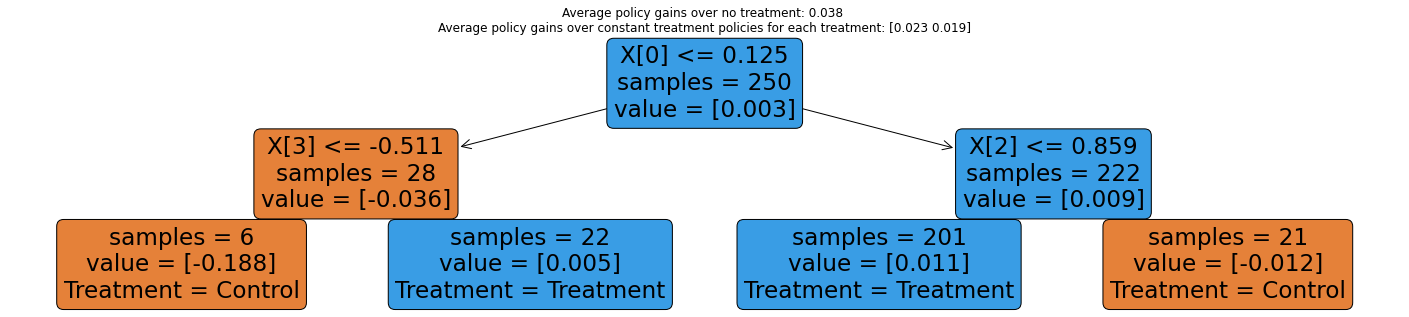

In [16]:
%matplotlib inline
plt.figure(figsize=(25, 5))
policy.plot(treatment_names = ["Control", "Treatment"])
plt.show()

Note how the treatment rule is rather transparent, in that whether or not each individual is treated depends only on a couple of if-statements. This can be very attractive in settings in which it's important to explain the policy to stakeholders, or reason about its consequences in terms of fairness (e.g., is it okay that these particular subgroups get the treatment?), manipulability (e.g., will individuals lie about their observable characteristics to get a better outcome?), and so on. 

To evaluate the policy, we again use what we learned in the previous chapter, remembering that we can only use the test set for evaluation. In randomized settings, we can use the following estimator based on sample averages.


In [17]:
a = pi_hat == 1
y1 = data.iloc[train : ][outcome]
w1 = data.iloc[train : ][treatment]
extr_val_sd(y1, w1, a)

Using the remaining AIPW scores produces an estimate that, in large samples, has smaller standard error.



In [18]:
# Using the remaining AIPW scores produces an estimate that, in large samples, has smaller standard error.
gamma_hat_pi = pi_hat + gamma_hat_1.iloc[int(n/2):] + (1 - pi_hat) * gamma_hat_0.iloc[int(n/2) : ]

val_st, val_sderr = np.mean(gamma_hat_pi), np.std(gamma_hat_pi) / np.sqrt(len(gamma_hat_pi))
val_st, val_sderr


A technical note. Very small policy tree leaves make it hard to reliably evaluate policy values, in particular when the treatment is categorical with many levels. You can avoid small tree leaves increasing the `min.node.size` argument in `policy_tree`.


[Possible edit here: talk about cross-validation?]


## Case study

Let's apply the methods above to our `welfare` dataset, as used in previous chapters.


In [19]:
# Read in data
data = pd.read_csv("https://docs.google.com/uc?id=1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC&export=download")

# Extract rows from data
n_row, ncol = data.shape

# ## NOTE: invert treatment and control, compared to the ATE and HTE chapters.

data['w'] = 1 - data['w']

# # Treatment is the wording of the question:
# # 'does the the gov't spend too much on 'assistance to the poor' (control: 0)
# # 'does the the gov't spend too much on "welfare"?' (treatment: 1)
treatment = "w"

# # Outcome: 1 for 'yes', 0 for 'no'
outcome = "y"

# # Additional covariates
covariates = ["age", "polviews", "income", "educ", "marital", "sex"]

It's important to note that there are different types of "heterogeneity" in treatment effects. Sometimes the effect of a treatment is positive throughout, and what changes is the magnitude of the effect. In this case, we would still like to treat everyone. On the other hand, sometimes the treatment effect is positive for certain subgroups and negative for others. The latter is a more interesting scenario for policy learning. 

In this dataset, however, the effect seems to be mostly positive throughout. That is, i.e., most individuals respond "yes" more often when they are asked about "welfare" than about "assistance to the poor". To make the problem more interesting, we'll artificially modify the problem by introducing a cost of asking about welfare. This is just for illustration here, although there are natural examples in which treatment is indeed costly. Note in the code below how we subtract a cost of `.3` from the AIPW scores associated with treatment.


In [20]:
# Prepare data
x = data[covariates]
y = data[outcome]
w = data[treatment]
cost = .3

# Fit a policy tree on forest-based AIPW scores
forest.tune(y, w, X=x, W=None)
forest_aipw = forest.fit(y, w, X=x, W=None, cache_values=True)
# time.sleep(5) 

gamma_hat_1, gamma_hat_0 = double_robust_score(forest_aipw, y, w, x)
# time.sleep(5)

# Substracting cost of treatment
gamma_hat_1 -= cost
gamma_mtrx = pd.DataFrame(
    {
        "gamm_hat_0" : gamma_hat_0,
        "gamm_hat_1": gamma_hat_1
    }
)

# Divide data into train and evaluation sets
train = int(n_row * .8)

# Fit policy on training subset
policy = PolicyTree(
    max_depth=2, honest=True, random_state=2
).fit(x.iloc[ : train], gamma_mtrx.iloc[ : train])

# Predicting leaves (useful later)
pi_hat = policy.predict(x.iloc[train : ])
leaf = policy.apply(x.iloc[train : ])
num_leave = len(set(leaf))
# policy.pre leaf by obsservacion

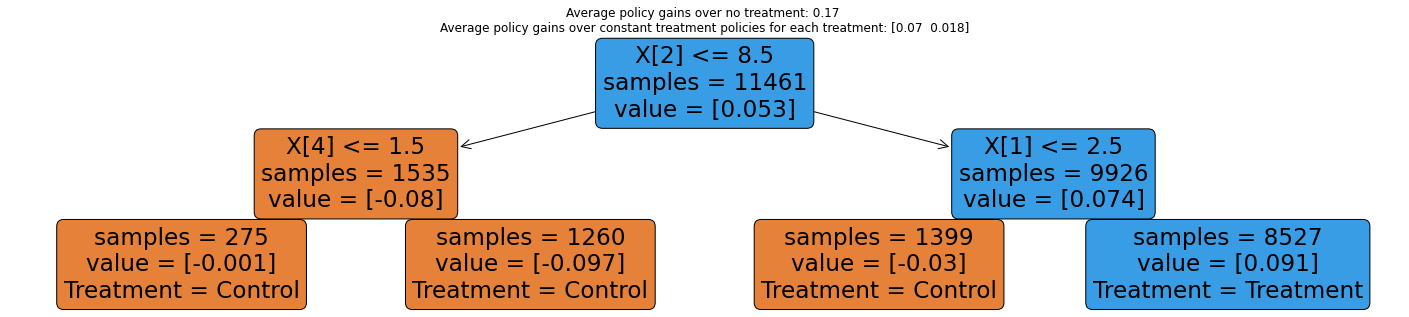

In [21]:
plt.figure(figsize=(25, 5))
policy.plot(treatment_names = ["Control", "Treatment"])
plt.show()

Estimating the value of the learned policy. Note in the code below that we must subtract the cost of treatment.



In [22]:
a = pi_hat == 1

y_test = y.iloc[train : ] 
w_test = w.iloc[train : ]

print("Print value estimate [sample avg], and standard error")

# Print Value_estimate [sample avg] 
extr_val_sd(y_test, w_test, a)

Print value estimate [sample avg], and standard error


In [23]:
# Valid in both randomized and obs setting with unconf + overlap.
### AIPW
### Results from double_robust_score(): gamma_hat_1, gamma_hat_0
gamma_hat_pi = pi_hat * (gamma_hat_1.iloc[train:]) + (1 - pi_hat) * gamma_hat_0.iloc[train : ]

print("Estimate [AIPW], Value Estiamte and standar error")
## Print Estimate [AIPW}
np.mean(gamma_hat_pi), np.std(gamma_hat_pi) / np.sqrt(len(gamma_hat_pi))

Estimate [AIPW], Value Estiamte and standar error


Testing whether the learned policy value is different from the value attained by the "no-treatment" policy.



In [24]:
# Only valid for randomized setting.
c_1 = a & (w_test == 1)
c_0 = np.logical_not(a) & (w_test == 0)

y_main = pd.DataFrame(y_test)
y_main['c_0'], y_main['c_1'] = c_0, c_1
y_0 = y_main.loc[y_main['c_0'] == True]['y']
y_1 = y_main.loc[y_main['c_1'] == True]['y']

diff_estimate = (np.mean(y_1) - cost - np.mean(y_0)) * np.mean(a)
diff_strerr = np.sqrt(np.var(y_1) / np.sum(c_1) * np.mean(a)**2 +  np.var(y_0) / np.sum(c_0) * np.mean(a)**2) 
diff_estimate, diff_strerr

gamma_hat_pi_diff = gamma_hat_pi - gamma_hat_0
diff_estimate = np.mean(gamma_hat_pi_diff)
diff_strerr = np.std(gamma_hat_pi_diff) / np.sqrt(len(gamma_hat_pi_diff))

print("Diference estimate [AIPW]:")
diff_estimate, diff_strerr

Diference estimate [AIPW]:


## Topics 1: Subgroups using learned policy

The learned policy naturally induces interesting subgroups for which we expect the treatment effect to be different. With appropriate sample splitting, we can test that treatment effect is indeed different across "regions" defined by assignment under the learned policy,

$$
  H_0: \mathop{\mathrm{E}}[Y_i(1) - Y_i(0)| \hat{\pi}(X_i) = 1] = \mathop{\mathrm{E}}[Y_i(1) - Y_i(0)| \hat{\pi}(X_i) = 0].
$$


In [25]:
## Olny from randomized settings

## subset test data

data_test = data.iloc[train : ]
data_test['pi_hat'] = pi_hat

## Formula
fmla = outcome + " ~ 0 + C(pi_hat) + w:C(pi_hat)"

ols = smf.ols(fmla, data=data_test).fit(cov_type='HC2')
ols_coef = ols.summary2().tables[1].reset_index()
ols_coef['Coef.'] = ols_coef['Coef.'] - cost
ols_coef.iloc[2:4, 0:3]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,Coef.,Std.Err.
2,w:C(pi_hat)[0],-0.100590,0.018995
3,w:C(pi_hat)[1],0.063474,0.012595


In [26]:
# Valid in randomized settings and observational settings with unconfoundedness+overlap

gamma_diff = gamma_hat_1 - gamma_hat_0

### gamma_diff as y 
ga_df = pd.DataFrame({'gamma_diff': gamma_diff}).iloc[train : ]
ga_df['pi_hat'] = pi_hat
gam_fml = "gamma_diff ~ 0 + C(pi_hat)"
ols = smf.ols(gam_fml, data = ga_df).fit(cov_type = "HC2").summary2().tables[1].reset_index()
ols

,index,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
0,C(pi_hat)[0],-0.098853,0.018109,-5.458833,4.792755e-08,-0.134345,-0.063360
1,C(pi_hat)[1],0.067495,0.012046,5.602905,2.107889e-08,0.043884,0.091105


If we learned a tree policy using the `policytree`, we can test whether treatment effects are different across leaves.

$$
  H_0: \mathop{\mathrm{E}}[Y_i(1) - Y_i(0)| \text{Leaf} = 1] = \mathop{\mathrm{E}}[Y_i(1) - Y_i(0)| \text{Leaf} = \ell] \qquad \text{for }\ell \geq 2
$$

In [27]:
# Only valid in randomized settings.
fmla = outcome + " ~ + C(leaf) + w:C(leaf)"

data_test['leaf'] = leaf
ols = smf.ols(fmla, data=data_test).fit(cov_type = "HC2")
ols_coef = ols.summary2().tables[1].reset_index()
ols_coef.loc[ols_coef["index"].str.contains(":")].iloc[:, 0:3]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,Coef.,Std.Err.
4,w:C(leaf)[2],0.204530,0.079246
5,w:C(leaf)[3],0.215679,0.032965
6,w:C(leaf)[5],0.189204,0.024332
7,w:C(leaf)[6],0.363474,0.012595


In [28]:
# Valid in randomized settings and observational settings with unconfoundedness+overlap.
ga_df['leaf'] = leaf
fml_gm = "gamma_diff ~ 0 + C(leaf)"
ols = smf.ols(fml_gm, data = ga_df).fit(cov_type = "HC2").summary2().tables[1].reset_index()
ols.iloc[:, 0:3]

,index,Coef.,Std.Err.
0,C(leaf)[2],-0.091141,0.068513
1,C(leaf)[3],-0.078357,0.030900
2,C(leaf)[5],-0.112214,0.023601
3,C(leaf)[6],0.067495,0.012046


Finally, as we have done in previous chapters, we can check how covariate averages vary across subgroups. This time, the subgroups are defined by treatment assignment under the learned policy.

$$
  H_0: \mathop{\mathrm{E}}[X_{ij} | \hat{\pi}(X_i) = 1] = \mathop{\mathrm{E}}[X_{ij} | \hat{\pi}(X_i) = 0] \qquad \text{for each covariate }j
$$


In [29]:
df = pd.DataFrame()

for var_name in covariates:
    form2 = var_name + " ~ 0 + C(pi_hat)"
    ols = smf.ols(formula=form2, data=data_test).fit(cov_type = 'HC2').summary2().tables[1].iloc[:, 0:2]
    
    nrow, ncol = ols.shape
    
    # Retrieve results
    toget_index = ols["Coef."]
    index = toget_index.index
    cova1 = pd.Series(np.repeat(var_name,nrow), index = index, name = "covariate")
    avg = pd.Series(ols["Coef."], name="avg")
    stderr = pd.Series(ols["Std.Err."], name = "stderr")
    # ranking = pd.Series(np.arange(1,nrow+1), index = index, name = "ranking")
    # ranking = pd.Series(np.array(["Control", "Treatment"]), index = index, name = "pi_hat"),
    scaling = pd.Series(norm.cdf((avg - np.mean(avg))/np.std(avg)), index = index, name = "scaling")
    # data2 = pd.DataFrame(data=X, columns= covariates)
    variation1= np.std(avg) / np.std(data[var_name])
    variation = pd.Series(np.repeat(variation1, nrow), index = index, name = "variation")
    labels = pd.Series(round(avg,2).astype('str') + "\n" + "(" + round(stderr, 2).astype('str') + ")", index = index, name = "labels")
    
    # Tally up results
    df1 = pd.DataFrame(data = [cova1, avg, stderr, scaling, variation, labels]).T
    df = df.append(df1)


df["pi_hat"] = ["Control", "Treatment"]*len(covariates) 
df.head(3)


,covariate,avg,stderr,scaling,variation,labels,pi_hat
C(pi_hat)[0],age,45.85355,0.488271,0.158655,0.048893,45.85\n(0.49),Control
C(pi_hat)[1],age,47.501028,0.250317,0.841345,0.048893,47.5\n(0.25),Treatment
C(pi_hat)[0],polviews,2.702663,0.040341,0.158655,0.673995,2.7\n(0.04),Control


Text(0.5, 1.0, 'Average covariate values within each leaf')

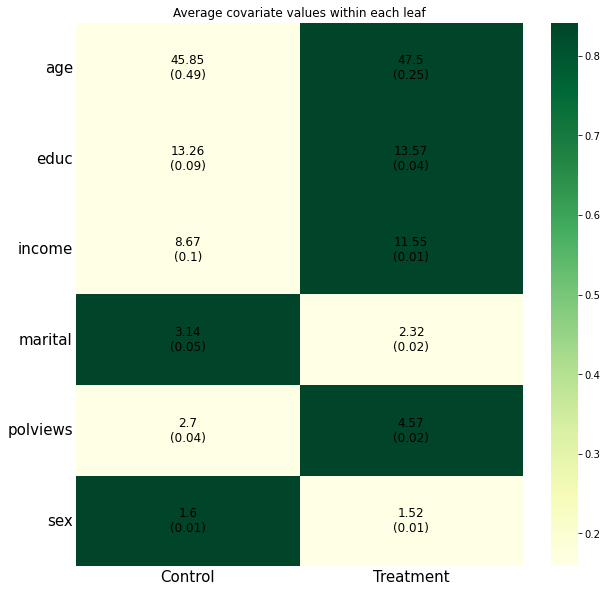

In [30]:
df1 = df.pivot("covariate", "pi_hat", "scaling").astype(float)
labels = df.pivot('covariate', 'pi_hat', 'labels').to_numpy()

ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    df1, annot=labels,
    annot_kws={"size": 12, 'color':"k"},
    fmt = '',
    cmap = "YlGn",
    linewidths=0
)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.xlabel("", fontsize= 10)
plt.ylabel("")
plt.title("Average covariate values within each leaf")


## Topics 2: Learning with uncertain costs


In the previous section, treatment costs were known and (just for simplicity of exposition) fixed across covariate values. However, there are situations in which costs are unknown and must be learned from the data as well. In such situations, we may interested only in policies that do not exceed a certain budget  in expectation.

Here, we follow [Sun, Du, Wager (2021)](https://arxiv.org/abs/2103.11066) for how to deal with this issue. Their formulation is as follows. In potential outcome notation, each observation can be described by the tuple $(X_i, Y_i(0), Y_i(1), C_i(0), C_i(1))$, where the new pair $(C_i(0), C_i(1))$ represents costs that would be realized if individuals were assigned to control or treatment. Of course, in the data we only observe the tuple $(X_i, W_i, Y_i, C_i)$, where $C_i \equiv C_i(W_i)$. We are interested in approximating the policy $\pi_B^*$ that maximizes the gain from treating relative to not treating anyone while kee\\ping the average relative cost bounded by some known budget $B$,

$$
  \\\pi_B^*(x) := \arg\max \mathop{\mathrm{E}}[Y(\pi(X_i))] - \mathop{\mathrm{E}}[Y_i(0)]  \quad \text{such that} \quad \mathop{\mathrm{E}}[C_i(\pi(X_i)) - C_i(0)] \leq B.
$$

This paper demonstrates that the optimal policy has the following structure. First, we can order observations in decreasing order according to the following priority ranking,

$$ 
  \rho(x) := 
    \frac{\mathop{\mathrm{E}}[Y_i(1) - Y_i(0) | X_i = x]}
         {\mathop{\mathrm{E}}[C_i(1) - C_i(0) | X_i = x]}.
$$ (rho)

Then, we assign treatment in decreasing order {eq}`rho` until we either treat everyone with positive $\rho(x)$ or the budget is met. The intuition is that individuals for which {eq}`rho` is high have a high expected treatment effect relative to cost, so by assigning them first we obtain a cost-effective policy. We stop once there's no one else for which treatment is expected to be positive or we run out of resources.

To obtain estimates $\hat{\rho}$ of {eq}`rho` from the data, we have two options. The first is to estimate the numerator $\widehat{\tau}(x) = \mathop{\mathrm{E}}[Y_i(1) - Y_i(0) |X_i = x]$ and the denominator $\hat{\widehat{\Gamma}}(x) = \mathop{\mathrm{E}}[C_i(1) - C_i(0) |X_i = x]$ separately, in a manner analogous to what we saw in the HTE chapter, and compute their ratio, producing the estimate $\hat{\rho}(x) = \widehat{\tau}(x) / \hat{\widehat{\Gamma}}(x)$. We'll see a second option below. 

Let's put the above into practice. For illustration, we will generate random costs for our data. We'll assume that the costs of treatment are drawn from a conditionally Exponential distribution, and that there are no costs for no treating.


In [31]:
# Creating random costs.
nrow, ncol = data.shape
cond = [data['w'] == 1]
# do_it = [12]
do_it = [np.random.uniform(0, 1, 1)]
data['cost'] = C = np.select(cond, do_it, 0)

The next snippet compares two kinds of policies. An "ignore costs" policy which, as the name suggests, orders individuals by $\hat{\tau}$ only without taking costs into account; and the "ratio" policy in which the numerator and denominator of {eq}`rho` are estimated separately. The comparison is made via a **cost curve** that compares the cumulative benefit of treatment with its cumulative cost (both normalized to 1), for all possible budgets at once. More cost-effective policies hug the left corner of the graph more tightly, kee\\ping away from the 45-degree line.



In [32]:
# Assuming that the assignment probability is known.
# If these are not known, they must be estimated from the data as usual.
e = 0.5  

y = data[outcome]
w = data[treatment]
x = data[covariates]

# Sample splitting. 
# Note that we can't simply rely on out-of-bag observations here.
train = int(nrow / 2)

# IPW-based estimates of (normalized) treatment and cost
n_test = int(nrow - nrow / 2)
treatment_ipw = 1 / n_test * (w.iloc[train : ] / e - (1 - w.iloc[train : ]) / (1 - e)) * y.iloc[train : ]
cost_ipw = 1 / n_test * w.iloc[train : ] / e * data['cost'].iloc[train : ]
forest = causal_forest(
    model_t=RegressionForest(),
    model_y=RegressionForest(),
    n_estimators=200, min_samples_leaf=5,
    max_depth=50, verbose=0, random_state=1
)
forest.tune(y.iloc[:train], w.iloc[:train], X=x.iloc[:train], W=None)

# # Compute predictions on test set
tau_forest = forest.fit(y.iloc[: train], w.iloc[: train], X=x.iloc[: train], W=None)
tau_hat = tau_forest.effect(x.iloc[train : ])

# Estimating the denominator.
# Because costs for untreated observations are known to be zero, we're only after E[C(1)|X].
# Under unconfoundedness, this can be estimated by regressing C on X using only the treated units.
gamm_forest = forest.fit(data['cost'].iloc[: train], w.iloc[: train], X=x.iloc[: train], W=None)
gamm_hat = gamm_forest.effect(x.iloc[train : ])

In [33]:
# Rankings
rank_ignore_cost = (-tau_hat).argsort()
rank_ratio = (-gamm_hat).argsort()

In [34]:
# Create w_hat_test data_frame
ipw = pd.DataFrame({'treatment_ipw': treatment_ipw, "cost_ipw": cost_ipw})
ipw['rank_ignore_cost'] = rank_ignore_cost
ipw['rank_ratio'] = rank_ratio

In [35]:
# Cumulative benefit and cost of treatment (normalized) for a policy that ignores costs.
treatment_value_ignore_cost = np.cumsum(ipw.sort_values("rank_ignore_cost")['treatment_ipw']) / np.sum(ipw['treatment_ipw'])
treatment_cost_ignore_cost = np.cumsum(ipw.sort_values("rank_ignore_cost")['cost_ipw']) / np.sum(ipw['cost_ipw'])

# Cumulative benefit and cost of treatment (normalized) for a policy that uses the ratio, estimated separately.
treatment_value_ratio = np.cumsum(ipw.sort_values("rank_ratio")['treatment_ipw']) / np.sum(ipw['treatment_ipw'])
treatment_cost_ratio = np.cumsum(ipw.sort_values("rank_ratio")['cost_ipw']) / np.sum(ipw['cost_ipw'])

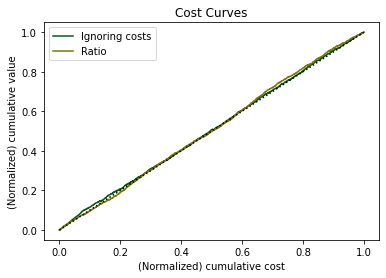

In [36]:
plt.plot(treatment_cost_ignore_cost, treatment_value_ignore_cost, '#0d5413', label='Ignoring costs')
plt.plot(treatment_cost_ratio, treatment_value_ratio, '#7c730d', label='Ratio')
plt.title("Cost Curves")
plt.xlabel("(Normalized) cumulative cost")
plt.ylabel("(Normalized) cumulative value")
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 1.5, linestyle = "dotted")
plt.legend()
plt.show()

To read this graph, we consider a point on the horizontal axis, representing a possible (normalized) budget constraint. At that point, whichever policy is higher is more cost-effective.

As the authors note, we can also estimate {eq}`rho` in a second way. First, they note that, under overlap and the following extended unconfoudedness assumption

$$
  \{Y_i(0), Y_i(1), C_i(1), C_i(0) \perp W_i | X_i \},
$$

we can rewrite {eq}`rho` as

$$
  \rho(x) := 
    \frac{\text{Cov}[Y_i, W_i | X_i = x]}
         {\text{Cov}[C_i, W_i | X_i = x]}.
$$ (rho-iv)

As readers with a little more background in causal inference may note, {eq}`rho-iv` coincides with the definition of the conditional local average treatment effect (LATE) if we _were_ to take $W_i$ as an "instrumental variable" and $C_i$ as the "treatment". In fact, instrumental variable methods require different assumptions, so the connection with instrumental variables is tenuous (see the paper for details), but mechanically {eq}`rho-iv` provides us with an estimation procedure: we can use any method used to estimate conditional LATE to produce an estimate $\hat{\rho}$.


In [37]:
# Estimating rho(x) directly via instrumental forests.
# In observational settings, remove the argument W.hat.
i_f = instrumental_forest().fit(x.iloc[:train], w.iloc[:train], y.iloc[:train], Z = data['cost'].iloc[:train])

In [38]:
# Predict and compute and estimate of the ranking on a test set.
rho_iv = i_f.predict(x.iloc[train : ])

In [39]:
# Create objects
ipw['rho_iv']  = rho_iv
ipw['rank_iv'] = (-rho_iv).argsort()

treatment_valu_iv = np.cumsum(ipw.sort_values("rank_iv")['treatment_ipw']) / sum(ipw['treatment_ipw'])
treatment_cost_iv = np.cumsum(ipw.sort_values("rank_iv")["cost_ipw"]) / sum(ipw['cost_ipw'])

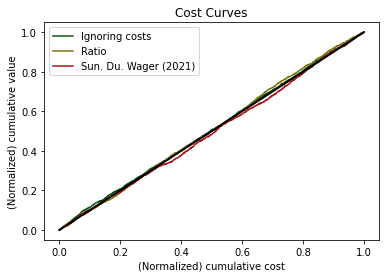

In [40]:
plt.plot(treatment_cost_ignore_cost, treatment_value_ignore_cost, '#0d5413', label='Ignoring costs')
plt.plot(treatment_cost_ratio, treatment_value_ratio, '#7c730d', label='Ratio')
plt.plot(treatment_cost_iv, treatment_valu_iv, "#af1313", label = "Sun. Du. Wager (2021)")
plt.title("Cost Curves")
plt.xlabel("(Normalized) cumulative cost")
plt.ylabel("(Normalized) cumulative value")
plt.legend()
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2)
plt.show()

In this example, both the “direct ratio” and the solution based on instrumental forests have similar performance. This isn’t always the case. When the ratio $\rho(x)$ is simpler relative to $\tau(x)$ and $\gamma(x)$, the solution based on instrumental forests may perform better since it is estimating $\rho(x)$ directly, where the “direct ratio” solution needs to estimate the more complicated objects $\tau(x)$ and $\gamma(x)$ separately. At a high level, we should expect $\rho(x)$ to be relatively simpler when there is a strong relationship between $\tau(x)$ and $\gamma(x)$. Here, our simulated costs seem to be somewhat related to CATE (see the plot below), but perhaps not strongly enough to make the instrumental forest solution noticeably better than the one based on ratios.

Text(0, 0.5, 'Esimated CATE (normalized)')

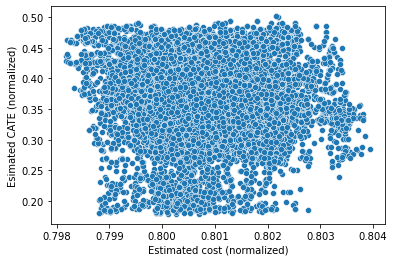

In [41]:
# plot
sns.scatterplot(x = gamm_hat, y = tau_hat)
plt.xlabel("Estimated cost (normalized)")
plt.ylabel("Esimated CATE (normalized)")

The different policies can be compared by the area between the curves they trace and the 45-degree line, with higher values indicating better policies.



In [42]:
t_c_i_c = pd.Series(np.array(treatment_cost_ignore_cost))
t_c_r = pd.Series(np.array(treatment_cost_ratio))
t_c_iv = pd.Series(np.array(treatment_cost_iv))
ignore = np.sum((np.array(treatment_value_ignore_cost) - t_c_i_c) * (t_c_i_c - t_c_i_c.shift(1)))
ratio = np.sum((np.array(treatment_value_ratio) - t_c_r) * (t_c_r - t_c_r.shift(1)))
iv = np.sum((np.array(treatment_valu_iv) - t_c_iv) * (t_c_iv - t_c_iv.shift(1)))

In [43]:
pd.DataFrame({
    "ig": ignore,
     "ratio": ratio,
    "iv" : iv
}, index = [0])


,ig,ratio,iv
0,0.006119,0.005742,-0.007943


## Further reading

The presentation of parametric policies was largely based on Athey and Wager (Econometrica, 2021). A slightly more accessible version of some of the material in the published version can be found in an earlier [ArXiv version](https://arxiv.org/abs/1702.02896v1) of the same paper. Policy comparisons via cost curves can also be found in [Imai and Li (2019)](https://arxiv.org/pdf/1905.05389.pdf).
